In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
from math import e
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from data.load import get_data, subsample
from data.utils import custom_cutout
from model import losses
from model.metrics import psnr, ssim

## Choose Devices

In [7]:
gpu_id = 4
num_cores = 4

In [8]:
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [9]:
nb_name = 'clr_expt_2'

## Load Data

In [10]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/self_sv/contrastive'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/contrastive


In [11]:
def get_clr_data(data_pth, hr_dir, bs, in_sz, out_sz,
                 xtra_tfms=None, num_workers=4, noise=None, 
                 max_zoom=1.1):
    src = get_clr_src(data_pth, hr_dir)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom,
                          xtra_tfms=xtra_tfms)
    data = (src
                .transform(tfms, size=in_sz, 
                           resize_method=ResizeMethod.CROP, tfm_y=False)
                .transform_y(None, size=out_sz, 
                             resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    data.valid_ds.tfms_y = None
    return data


def get_clr_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src

In [12]:
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=5, max_length=10, use_on_y=False)

In [13]:
patch_tfms = [random_patch()]

In [14]:
# Create databunch
size = 128
bs = 64
data = get_clr_data(data_pth, hr_dir, bs, xtra_tfms=patch_tfms,
                    in_sz=size, out_sz=size)

## Data Subsample

In [15]:
data = subsample(data)

# Model

In [16]:
class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) 
    to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the 
    output after the average pooling layer.
    """

    def __init__(self, arch="resnet50", projection_dim=128, 
                 normalize=True):
        super(SimCLR, self).__init__()

        self.encoder = self.get_arch(arch)
        self.normalize = normalize

        self.n_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )
        

    def get_arch(self, name):
        resnets = {
            "resnet18": models.resnet18(),
            "resnet34": models.resnet34(),
            "resnet50": models.resnet50()
        }
        if name not in resnets.keys():
            raise KeyError(f"{name} is not a valid architecture")
        return resnets[name]


    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)

        if self.normalize:
            z = nn.functional.normalize(z, dim=1)
        return z

In [17]:
class ContrastiveCallback(LearnerCallback):
    def __init__(self, learn:Learner):
        super().__init__(learn)
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        xb_1 = last_input # (bs x w x h)
        xb_2 = last_target
        xb = (torch.cat([xb_1, xb_2], dim=0),) # (bs*2 x w x h)
        return {'last_input': xb, 'last_target': torch.tensor([1.])}

# Loss

In [18]:
class NT_Xent(nn.Module):
    def __init__(self, 
                 temperature=0.1, device=0):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.device = f'cuda:{device}'

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        mask = torch.ones((batch_size * 2, batch_size * 2), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_all, useless):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
#         pdb.set_trace()
        self.batch_size = z_all.shape[0] // 2
        self.mask = self.mask_correlated_samples(self.batch_size)
        sim = self.similarity_f(z_all.unsqueeze(1), z_all.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
#         pdb.set_trace()
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(
            self.batch_size * 2, 1
        )
        negative_samples = sim[self.mask].reshape(self.batch_size * 2, -1)

        labels = torch.zeros(self.batch_size * 2).to(self.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= 2 * self.batch_size
        return loss

In [19]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 3, 128, 128]))

# Critic Creation

In [20]:
m = SimCLR(arch='resnet34')
nce = NT_Xent(device=gpu_id)

In [21]:
wd = 1e-3
learn = Learner(data, m, loss_func=nce,
                wd=wd, model_dir=model_pth)

In [22]:
critic = learn.load(f'{nb_name}.3b')
encoder = critic.model.encoder.eval().cuda()
feature_maps = losses.find_layers(losses.flatten_model(encoder))
num_layers = len(feature_maps)

In [23]:
feat_loss = losses.FeatureLoss(m_feat=encoder, layer_wgts=[1/num_layers for _ in range(num_layers)])

In [22]:
critic.destroy()
del(critic)
torch.cuda.empty_cache()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


0

In [31]:
encoder.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 1.0514e-02,  8.5740e-02,  2.5614e-02,  ...,  9.2728e-03,
                          1.0462e-01,  6.7468e-02],
                        [ 6.2203e-02, -1.1261e-03,  2.9790e-02,  ...,  1.3869e-02,
                          2.3156e-02,  4.6475e-02],
                        [ 5.2289e-02,  8.2537e-02,  3.3440e-02,  ...,  3.6193e-02,
                          3.6868e-02,  5.2125e-02],
                        ...,
                        [-1.5077e-02,  2.8765e-02,  1.2478e-02,  ...,  1.0302e-02,
                          4.9436e-02,  5.5642e-02],
                        [ 2.1686e-02, -2.0744e-02,  1.0727e-02,  ..., -2.0308e-01,
                         -1.3299e-01, -5.4387e-02],
                        [-4.1964e-02, -2.4025e-02, -5.4987e-02,  ..., -2.9041e-01,
                         -2.9082e-01, -2.3982e-01]],
              
                       [[ 1.4578e-02,  8.1547e-02,  1.0323e-01,  ...,  5.9809e-02,
                          2.1889

# PSSR Creation

In [32]:
def get_data(data_pth, lr_dir, hr_dir, bs, in_sz, out_sz,
             c_out=3, num_workers=4, noise=None, max_zoom=1.1):
    src = get_src(data_pth, lr_dir, hr_dir)
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    data = (src
            .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP)
            .transform_y(tfms, size=out_sz, resize_method=ResizeMethod.CROP)
            .databunch(bs=bs, num_workers=num_workers)
            .normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def get_src(data_pth, lr_dir, hr_dir, seed=49):
    hr_tifs = data_pth/f'{hr_dir}'
    lr_tifs = data_pth/f'{lr_dir}'

    def map_to_hr(x):
        return Path(str(hr_tifs/x.relative_to(lr_tifs).with_suffix(".tif")).replace('lr', 'hr'))

    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_rand_pct(seed=seed)
            .label_from_func(map_to_hr))
    return src

In [33]:
nb_name = 'clr-pretrained-toddler'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
model_path = data_pth/f'EM/models/self_sv/contrastive'

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, c_out=3, max_zoom=6.)
db = subsample(db, seed=42)

In [34]:
superres_metrics = [F.mse_loss, psnr, ssim]

In [35]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(db, arch, wd=wd, pretrained=True,
                         loss_func=feat_loss,
                         metrics=superres_metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

0

## Initialization

In [36]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/contrastive


## Load Model (optional)

In [38]:
learn.model.state_dict()

OrderedDict([('layers.0.0.weight',
              tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
                          3.0660e-02,  2.5398e-02],
                        [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
                          2.9754e-02,  4.1735e-02],
                        [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
                         -1.1601e-01, -1.2191e-01],
                        ...,
                        [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
                          2.4631e-03,  1.6726e-02],
                        [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
                          7.3973e-02,  5.9085e-02],
                        [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
                          8.3749e-02,  9.6970e-02]],
              
                       [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
                          2

In [28]:
# learn.model_dir = model_pth
# learn = learn.load(f'{nb_name}.1b')

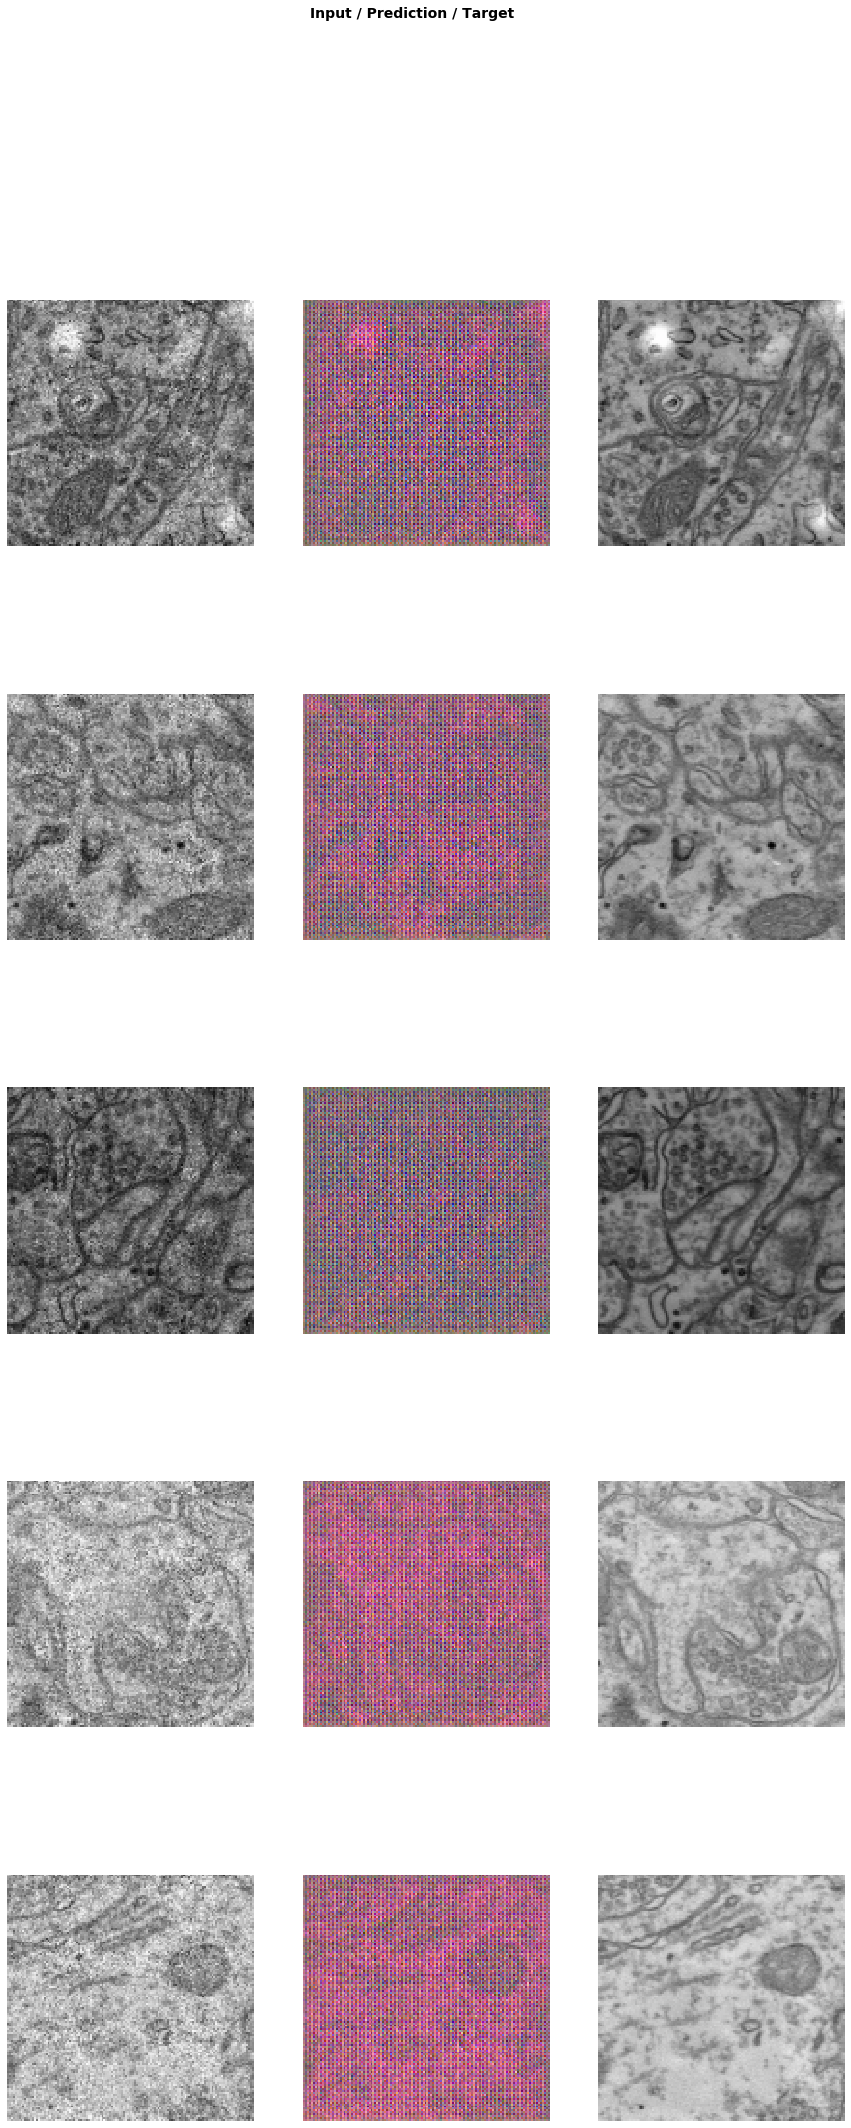

In [29]:
learn.show_results(rows=5, figsize=(15,35))

## Training

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time


### 1a

In [ ]:
lr = 1e-3
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(30,24))

In [ ]:
len(learn.data.valid_dl)

### 1b

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(15, 25))

## 2a

In [ ]:
# loading 3 rounds of data
bs_2 = 32
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)
db = subsample(db, seed=42)

In [ ]:
learn.data = db

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn = learn.load(f'{nb_name}.1b')

In [ ]:
lr = 3e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(15, 25))

## 2b

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn = learn.load(f'{nb_name}.2a')

In [ ]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(15, 25))

## 3a

In [ ]:
# loading 3 rounds of data
bs_3 = 8
size_3 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=1.)
db = subsample(db, seed=42)

In [ ]:
learn.data = db
learn.data

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3a', with_opt=False)

In [ ]:
learn = learn.load(f'{nb_name}.3a')

In [ ]:
learn.show_results(rows=5, figsize=(15, 25))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = slice(3e-5, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(15, 25))

In [22]:
learn.validate()

[0.39284357, tensor(0.0682), tensor(20.0004), tensor(0.2707)]

In [22]:
learn = learn.load(f'{nb_name}.3b')